# Code

# TODO 
Sono partito dai positivi di

FINETUNING = False

TRAIN_HQ = True

Devo creare le finestre dei negativi, e poi anche tutte le altre combinazioni.

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import time
import os
import re
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import sys
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
sys.path.insert(0, '..')
from tqdm.notebook import tqdm
import seaborn as sns
import util.misc as utils
from util.params_dataloader import load_windows_and_multipliers
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    RNADatasetNT500,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    HFDataset,
    HFDataLoader, 
    create_augment_list,
    plot_sample,
    seed_everything,
    clean_nt_dataframes_before_class_input,
)
from train_binary_cl import seed_worker, obtain_train_dataset, obtain_val_dataset, obtain_val_dataset_paris, obtain_train_dataset_paris, undersample_df, obtain_policies_object, obtain_dataset_object, get_per_sample_from_proportion
from config import *

<class 'transformers.tokenization_dna.DNATokenizer'>


# TODO

- CONTROLLA COSA REGOLANO SCALING_FACTOR=5, MAX_N_GROUPS = 80 e verifica che la minor lunghezza registrata in 10 epoche generi dei gruppi che siano >= di min_groups_train.
- VEDI VALIDATION500 (E TEST500 PER FINETUNING) COME FUNZIONANO NEL TRAINING, CIOE SE VENGONO CAMPIONATI DAI NEGATIVI SOLO GLI SMARTNEG O ANCHE HN,EN
- VERIFICA CHE VENGANO PRESI SOLO I SAMPLE DENTRO LE LISTE DI TRAINING / VALIDATION / TEST

In [3]:
DIMENSION = 200
FINETUNING = False
TRAIN_HQ = True
SPECIE = 'all'

scaling_factor = 5
min_n_groups_train = 5
max_n_groups_train = 80
min_n_groups_val = 80
max_n_groups_val = 80


DESIRED_DIM_TEST = 500

# Esecuzione data loader train

In [4]:
per_sample_p = 0.25
proportion_sn = 0.5
proportion_hn = 0.3
proportion_en = 0.2

### Dataset

In [5]:
n_epochs = 5
sn_len_1 = []
sn_len_2 = []
enhn_len_1 = []
enhn_len_2 = []
pos_len_1 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

all_couples_id = []

for epoch in tqdm(range(n_epochs)):
    dataset_train, policies_train = obtain_train_dataset_paris(DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            if sample.policy == 'smartneg':
                sn_len_1.append(box.x2-box.x1)
                sn_len_2.append(box.y2-box.y1)
            else:
                enhn_len_1.append(box.x2-box.x1)
                enhn_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))

        g1 = re.search('(.*)_(.*)_(.*)', sample.gene1).group(1)
        g2 = re.search('(.*)_(.*)_(.*)', sample.gene2).group(1)
        all_couples_id.append(g1 + '_' + g2)
        all_couples_id.append(g2 + '_' + g1)

pos_len = pos_len_1+pos_len_2
label_p = ['p' for i in range(len(pos_len))]
sn_len = sn_len_1+sn_len_2
label_sn = ['sn' for i in range(len(sn_len))]
enhn_len = enhn_len_1+enhn_len_2
label_enhn = ['enhn' for i in range(len(enhn_len))]
label = label_p + label_sn + label_enhn
length = pos_len + sn_len + enhn_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20754 [00:00<?, ?it/s]

  0%|          | 0/20569 [00:00<?, ?it/s]

  0%|          | 0/20478 [00:00<?, ?it/s]

  0%|          | 0/20526 [00:00<?, ?it/s]

  0%|          | 0/20618 [00:00<?, ?it/s]

(0.0, 1000.0)

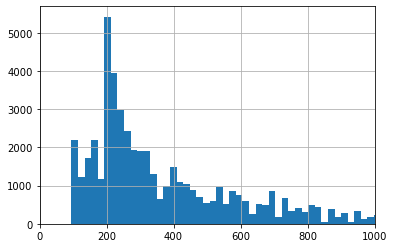

In [6]:
df_len[df_len.label == 'sn'].length.hist(bins = 300)
plt.xlim((0,1_000))
#plt.xlim((1_000,6_000))

(0.0, 1000.0)

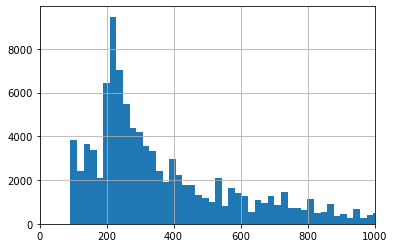

In [7]:
df_len[df_len.label == 'p'].length.hist(bins = 300)
plt.xlim((0,1_000))
#plt.xlim((1_000,6_000))

(0.0, 1000.0)

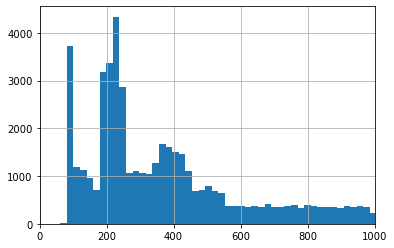

In [8]:
df_len[df_len.label == 'enhn'].length.hist(bins = 300)
plt.xlim((0,1_000))
#plt.xlim((1_000,6_000))

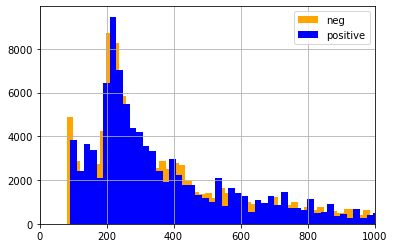

In [9]:
df_len[(df_len.label == 'sn')|(df_len.label == 'enhn')].length.hist(bins = 300, color = 'orange', label = 'neg')
df_len[df_len.label == 'p'].length.hist(bins = 300, color = 'blue', label = 'positive')
plt.legend()
plt.xlim((0,1_000))
plt.show()

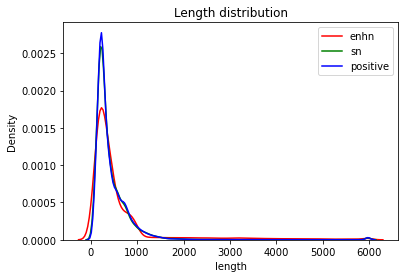

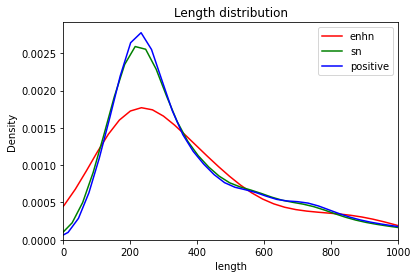

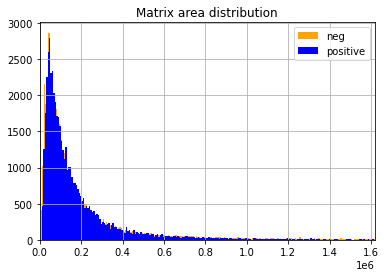

In [10]:
sns.kdeplot(df_len[df_len.label == 'enhn'].length, color = 'red', label = 'enhn')
sns.kdeplot(df_len[df_len.label == 'sn'].length, color = 'green', label = 'sn')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()

sns.kdeplot(df_len[df_len.label == 'enhn'].length, color = 'red', label = 'enhn')
sns.kdeplot(df_len[df_len.label == 'sn'].length, color = 'green', label = 'sn')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.xlim((0,1_000))
plt.show()

pd.Series(matrix_area_neg).hist(bins = 5_000, label = 'neg', color = 'orange')
pd.Series(matrix_area_pos).hist(bins = 5_000, label = 'positive', color = 'blue')
plt.title(f'Matrix area distribution')
plt.legend()
plt.xlim((0,np.mean(matrix_area_pos) * 8))
plt.show()

In [11]:
# plot_sample(sample, plot_interaction_negatives=True)

In [12]:
(df_len.label == 'p').value_counts()

True     102964
False    102926
Name: label, dtype: int64

In [13]:
df_len.sort_values('length').tail(500).label.value_counts() #5970

p       258
enhn    134
sn      108
Name: label, dtype: int64

In [14]:
df_len.sort_values('length').head(500).label.value_counts() #MIN_RNA_SIZE_DATALOADER

enhn    270
p       132
sn       98
Name: label, dtype: int64

In [15]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.7)
print(df_len[df_len['length'] > big_l].label.value_counts())

p       8581
enhn    6450
sn      4513
Name: label, dtype: int64


p       30404
enhn    16338
sn      15019
Name: label, dtype: int64


In [16]:
(float(df_len.sort_values('length').quantile(0.2))/6)/80

0.4166666666666667

In [17]:
(float(df_len.sort_values('length').quantile(0.5))/6)/80

0.6395833333333333

In [18]:
#balance set
assert abs(df_len.label.value_counts().p/df_len.shape[0] - 0.5) < 0.05

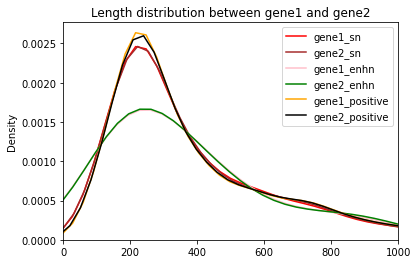

In [19]:
sns.kdeplot(sn_len_1, color = 'red', label = 'gene1_sn')
sns.kdeplot(sn_len_2, color = 'brown', label = 'gene2_sn')
sns.kdeplot(enhn_len_1, color = 'pink', label = 'gene1_enhn')
sns.kdeplot(enhn_len_2, color = 'green', label = 'gene2_enhn')
sns.kdeplot(pos_len_1, color = 'orange', label = 'gene1_positive')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.xlim((0,1_000))
plt.show()

### Dataloader 

In [20]:
dataset_train, policies_train = obtain_train_dataset_paris(DIMENSION, TRAIN_HQ, FINETUNING, per_sample_p, proportion_sn, proportion_hn, proportion_en, min_n_groups_train, max_n_groups_train, SPECIE, scaling_factor = 5)
sampler_train = torch.utils.data.RandomSampler(dataset_train)
batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, 32, drop_last=False)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn_nt2, num_workers=2)

In [ ]:
shapes_rna1 = []
shapes_rna2 = []
for (samples, labels) in tqdm(data_loader_train):
    rna1, rna2 = samples
    shapes_rna1.append(rna1.shape[-1])
    shapes_rna2.append(rna2.shape[-1])

In [22]:
np.min(shapes_rna1)

16

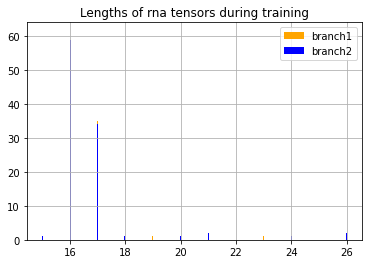

In [23]:
pd.Series(shapes_rna1).hist(bins = 300, color = 'orange', label = 'branch1')
pd.Series(shapes_rna2).hist(bins = 300, color = 'blue', label = 'branch2')
plt.legend()
#plt.xlim((0,100))
plt.title('Lengths of rna tensors during training')
plt.show()

# Validation set 

In [4]:
dataset_val, policies_val = obtain_val_dataset_paris(DIMENSION, FINETUNING, min_n_groups_val, max_n_groups_val, SPECIE, scaling_factor = 5)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14180 [00:00<?, ?it/s]

median: 200.0


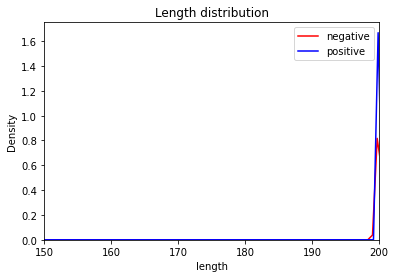

In [7]:
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(1)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.xlim((150, 200))
plt.legend()

# Esecuzione data loader external dataset

In [289]:
dataset = 'ricseq'

df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{dataset}.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{dataset}.csv'))
df_nt, df_genes_nt = clean_nt_dataframes_before_class_input(df_nt, df_genes_nt)
data_dir = os.path.join(rna_rna_files_dir, f'{dataset}')
file_training = os.path.join(data_dir, 'gene_pairs_training.txt')
with open(file_training, "rb") as fp:   # Unpickling
    train_couples = pickle.load(fp)
    
file_test = os.path.join(data_dir, 'gene_pairs_test.txt')
with open(file_test, "rb") as fp:   # Unpickling
    test_couples = pickle.load(fp)
    
train_nt = df_nt[df_nt.couples_id.isin(train_couples)].reset_index(drop = True)
test_nt = df_nt[df_nt.couples_id.isin(test_couples)].reset_index(drop = True)

In [290]:
scaling_factor = 5

if dataset == 'splash':
    pos_multipliers = {2:0.7, 8:0.1, 15:0.1, 50:0.1, 100:0.1}
    neg_multipliers = {7:0.5, 15:0.3, 50:0.15, 100:0.15}

elif dataset == 'mario':
    pos_multipliers = {5:0.7, 15:0.2, 50:0.1, 100:0.1}
    neg_multipliers = {5:0.1, 6:0.35, 15:0.2, 50:0.15, 100:0.2}

elif dataset == 'ricseq':
    pos_multipliers = {3:0.8, 40:0.15, 100:0.05}
    neg_multipliers = {6:0.73, 70:0.13, 100:0.13}

vc_train = train_nt.interacting.value_counts()
if vc_train[False]>vc_train[True]:
    unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]
    policies_train = obtain_policies_object(0.25, 0.25*unbalance_factor, pos_multipliers, neg_multipliers)
elif vc_train[False]<vc_train[True]:
    unbalance_factor = 1 - (vc_train[True] - vc_train[False]) / vc_train[True]
    policies_train = obtain_policies_object(0.25*unbalance_factor, 0.25, pos_multipliers, neg_multipliers)
elif vc_train[True]==vc_train[True]:
    unbalance_factor = 1

In [291]:
if dataset == 'ricseq':
    dataset_ricseq = obtain_dataset_object(policies_train, df_genes_nt, train_nt, '', scaling_factor, min_n_groups_train, max_n_groups_train)
elif dataset == 'splash':
    dataset_splash = obtain_dataset_object(policies_train, df_genes_nt, train_nt, '', scaling_factor, min_n_groups_train, max_n_groups_train)

In [292]:
n_epochs = 50
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

all_couples_id = []

for epoch in tqdm(range(n_epochs)):
    dataset_train = obtain_dataset_object(policies_train, df_genes_nt, train_nt, '', scaling_factor, min_n_groups_train, max_n_groups_train)
    for sample in dataset_train:
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
        g1 = re.search('(.*)_(.*)_(.*)', sample.gene1).group(1)
        g2 = re.search('(.*)_(.*)_(.*)', sample.gene2).group(1)
        all_couples_id.append(g1 + '_' + g2)
        all_couples_id.append(g2 + '_' + g1)
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/50 [00:00<?, ?it/s]

In [293]:
print(len(set(train_couples)))
print(len(set(test_couples)))
print(len(set(all_couples_id)))
print('\n')
print(len(set(all_couples_id).intersection(train_couples)))
print(len(set(all_couples_id).intersection(test_couples)))
print('\n')
print(len(set(train_couples) - set(all_couples_id)))
print(len(set(test_couples) - set(all_couples_id)))

11938
5120
38040


0
0


11938
5120


In [294]:
df_len.label.value_counts()

n    159504
p    159178
Name: label, dtype: int64

In [295]:
df_len.sort_values('length').head(500).label.value_counts()

p    468
n     32
Name: label, dtype: int64

In [296]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

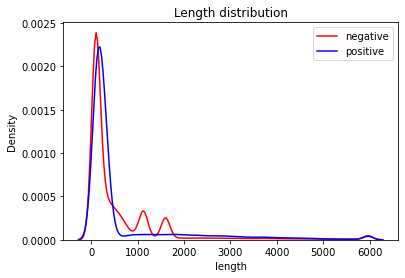

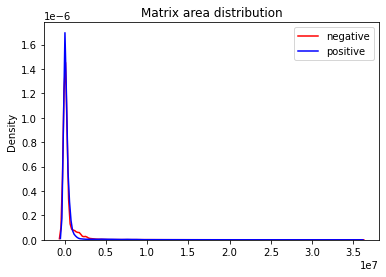

In [297]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

### Validation

In [170]:
dataset = 'mario'

In [150]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{dataset}.csv'))
data_dir = os.path.join(rna_rna_files_dir, f'{dataset}')

file_test = os.path.join(data_dir, 'gene_pairs_test.txt')
with open(file_test, "rb") as fp:   # Unpickling
    test_couples = pickle.load(fp)

df500 = pd.read_csv(os.path.join(metadata_dir, f'{dataset}500.csv'))
assert df500.shape[0] == df_nt[['couples', 'couples_id', 'interacting', 'policy']].merge(df500, on = 'couples').shape[0]
df500 = df_nt[['couples', 'interacting', 'policy', 'couples_id']].merge(df500, on = 'couples')
df500 = df500[df500.couples_id.isin(test_couples)]
df500 = df500[df500.policy.isin(['easypos', 'smartneg'])]
df500 = undersample_df(df500)

df500 = df500.sample(frac=1, random_state=23).reset_index(drop = True)
assert df500.shape[0]>0

dataset_val = RNADatasetNT500(
    df = df500,
    data_dir = os.path.join(embedding_dir, '32'),
    scaling_factor = scaling_factor,
    min_n_groups = min_n_groups_val,
    max_n_groups = max_n_groups_val,
)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

median: 500.0


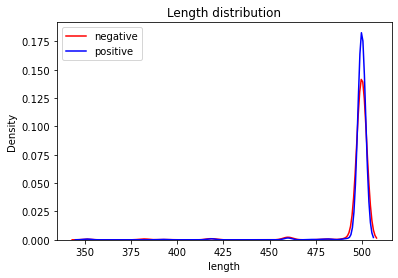

In [151]:
n_epochs = 10
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()

# Combined dataset 1

In [4]:
import torch
from torch.utils.data import Dataset, ConcatDataset, DataLoader

# Custom dataset class to undersample the first two datasets
class UndersampledDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.length = min(len(dataset) for dataset in datasets)

    def __len__(self):
        return self.length * len(self.datasets)

    def __getitem__(self, index):
        dataset_idx = index // self.length
        sample_idx = index % self.length
        return self.datasets[dataset_idx][sample_idx]

In [ ]:
n_epochs = 10
batch_size = 32

for epoch in tqdm(range(n_epochs)):

    # Create UndersampledDataset with the concatenated dataset
    undersampled_dataset = UndersampledDataset([dataset_ricseq, dataset_splash, dataset_paris])
    undersampled_dataset = UndersampledDataset([dataset_splash, dataset_paris])
    # Create DataLoader using the undersampled dataset
    custom_data_loader = DataLoader(undersampled_dataset, batch_size=batch_size, shuffle=True, collate_fn=utils.collate_fn_nt3)

    neg_len_1 = []
    pos_len_1 = []
    neg_len_2 = []
    pos_len_2 = []
    matrix_area_neg = []
    matrix_area_pos = []

    for s, targets in custom_data_loader: #tqdm(custom_data_loader, total = len(custom_data_loader)):
        for sample in targets:
            box = sample['bbox']
            if sample['interacting']==1:
                pos_len_1.append(box.x2-box.x1)
                pos_len_2.append(box.y2-box.y1)
                matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
            else:
                neg_len_1.append(box.x2-box.x1)
                neg_len_2.append(box.y2-box.y1)
                matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))

neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [307]:
len(neg_len)/2

360.0

In [308]:
len(pos_len)/2

372.0

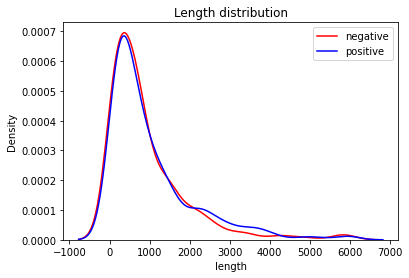

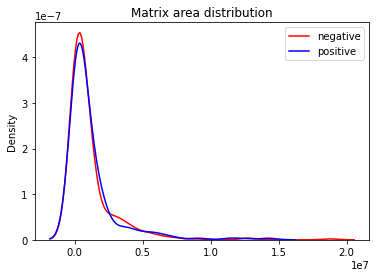

In [309]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

# Combined dataset 2

In [6]:
dataset_splash, policies_splash = obtain_train_dataset('splash', False, False, True, 5, 100, 'human')
dataset_paris, policies_paris = obtain_train_dataset('paris', False, False, True,5, 100, 'human')

/data01/giorgio/RNARNA-NT/src/train_binary_cl.py:316: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  dataset_train, policies_train = obtain_train_dataset_paris(easy_pretraining, train_hq, finetuning, min_n_groups_train, max_n_groups_train, specie, scaling_factor)


In [7]:
import torch
from torch.utils.data import Dataset, ConcatDataset, DataLoader

class MergedDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.lengths = [len(dataset) for dataset in datasets]
        self.total_length = sum(self.lengths)

    def __len__(self):
        return self.total_length

    def __getitem__(self, index):
        for i, length in enumerate(self.lengths):
            if index < length:
                return self.datasets[i][index]
            index -= length

In [ ]:
n_epochs = 10
batch_size = 32

for epoch in tqdm(range(n_epochs)):

    # Create UndersampledDataset with the concatenated dataset
    undersampled_dataset = MergedDataset([dataset_splash, dataset_paris])
    # Create DataLoader using the undersampled dataset
    custom_data_loader = DataLoader(undersampled_dataset, batch_size=batch_size, shuffle=True, collate_fn=utils.collate_fn_nt3)

    neg_len_1 = []
    pos_len_1 = []
    neg_len_2 = []
    pos_len_2 = []
    matrix_area_neg = []
    matrix_area_pos = []

    for s, targets in tqdm(custom_data_loader, total = len(custom_data_loader)): #tqdm(custom_data_loader, total = len(custom_data_loader)):
        for sample in targets:
            box = sample['bbox']
            if sample['interacting']==1:
                pos_len_1.append(box.x2-box.x1)
                pos_len_2.append(box.y2-box.y1)
                matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
            else:
                neg_len_1.append(box.x2-box.x1)
                neg_len_2.append(box.y2-box.y1)
                matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))

neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [10]:
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [11]:
len(neg_len)/2

329.0

In [12]:
len(pos_len)/2

311.0

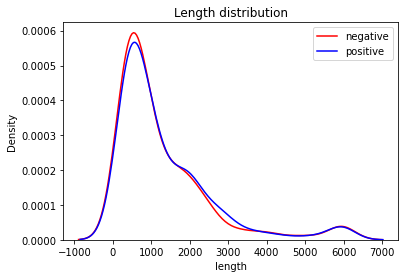

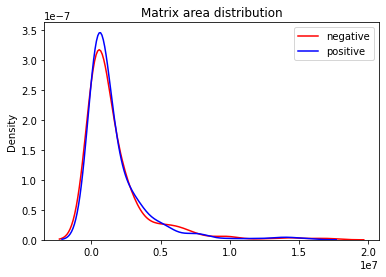

In [13]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()